# 1. Setting up

In [1]:
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
!nvidia-smi

Sat Feb 22 10:27:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   36C    P3              9W /   55W |      12MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Data preparation

## a) Checking images

In [3]:
import os

data_path = "data"
test_path = data_path + "/test"
train_path = data_path + "/train"

In [4]:
def walk_through_dir(dir):
    for dirpaths, dirnames, filenames in os.walk(dir):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpaths}")
walk_through_dir(data_path)

There are 2 directories and 0 images in data
There are 4 directories and 0 images in data/train
There are 0 directories and 274 images in data/train/Asian
There are 0 directories and 234 images in data/train/Indian
There are 0 directories and 243 images in data/train/Caucasian
There are 0 directories and 262 images in data/train/Negroid
There are 4 directories and 0 images in data/test
There are 0 directories and 69 images in data/test/Asian
There are 0 directories and 29 images in data/test/Indian
There are 0 directories and 30 images in data/test/Caucasian
There are 0 directories and 66 images in data/test/Negroid


### Check the sizes of the images

In [5]:
from PIL import Image
import os
from collections import Counter

In [6]:
size_counts = Counter()
for subfolder in os.listdir(train_path):
    subfolder_path = train_path + "/" + subfolder
    for filename in os.listdir(subfolder_path):
            file_path = subfolder_path + "/" + filename
            with Image.open(file_path) as img:
                size = img.size  # (width, height)
                size_counts[size] += 1

for size, count in size_counts.items():
    print(f'Size {size}: {count} images')

Size (256, 256): 1013 images


## b) Creating datasets

In [7]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_path)
test_data = datasets.ImageFolder(root=test_path)
class_names = train_data.classes

## c) Data preprocessing

### i) Datasets before

In [8]:
def imgs_per_class(dataset):
    result = {}
    labels = [label for _, label in dataset.samples]
    class_counts = Counter(labels) 
    for class_ind, num in class_counts.items():
        result[class_names[class_ind]] = num
    return result
class_train_imgs = imgs_per_class(train_data)
class_train_imgs

{'Asian': 274, 'Caucasian': 243, 'Indian': 234, 'Negroid': 262}

### ii) Calculate class weights

In [9]:
class_counts = list(imgs_per_class(train_data).values())
class_weights = [1.0 / class_imgs for class_imgs in class_counts]   
class_weights = torch.tensor(class_weights)
class_weights

tensor([0.0036, 0.0041, 0.0043, 0.0038])

### iii) Upsampling

In [10]:
# import numpy as np
# from torch.utils.data import Subset

# # Find the largest class size
# labels = [labels for _, labels in train_data.samples]
# class_counts = Counter(labels) 
# max_class_count = max(class_counts.values())

# # Upsample minority class
# new_train_data = []
# for class_ind in class_counts.keys():
#     # Find indices of current class
#     class_indices = [i for i, label in enumerate(labels) if label == class_ind]
#     print(class_indices)
#     # Repeat indices 
#     upsampled_indices = np.random.choice(class_indices, max_class_count, replace=True)
#     new_train_data.extend(train_data.samples[i] for i in upsampled_indices)
# train_data.samples = new_train_data

### iv) Datasets after

In [11]:
imgs_per_class(train_data)

{'Asian': 274, 'Caucasian': 243, 'Indian': 234, 'Negroid': 262}

## d) Creating transforms and apply data augmentation

In [12]:
from torchvision import transforms

img_transform = transforms.Compose([
    # transforms.Lambda(lambda img: img.convert('RGBA').convert('RGB')),
    transforms.Resize(size=(224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()  
])
train_data.transform = img_transform
test_data.transform = simple_transform

## e) Turn datasets into dataloaders

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, 
                              num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, 
                             num_workers=num_workers, shuffle=False)

## f) Visualize the images after changes

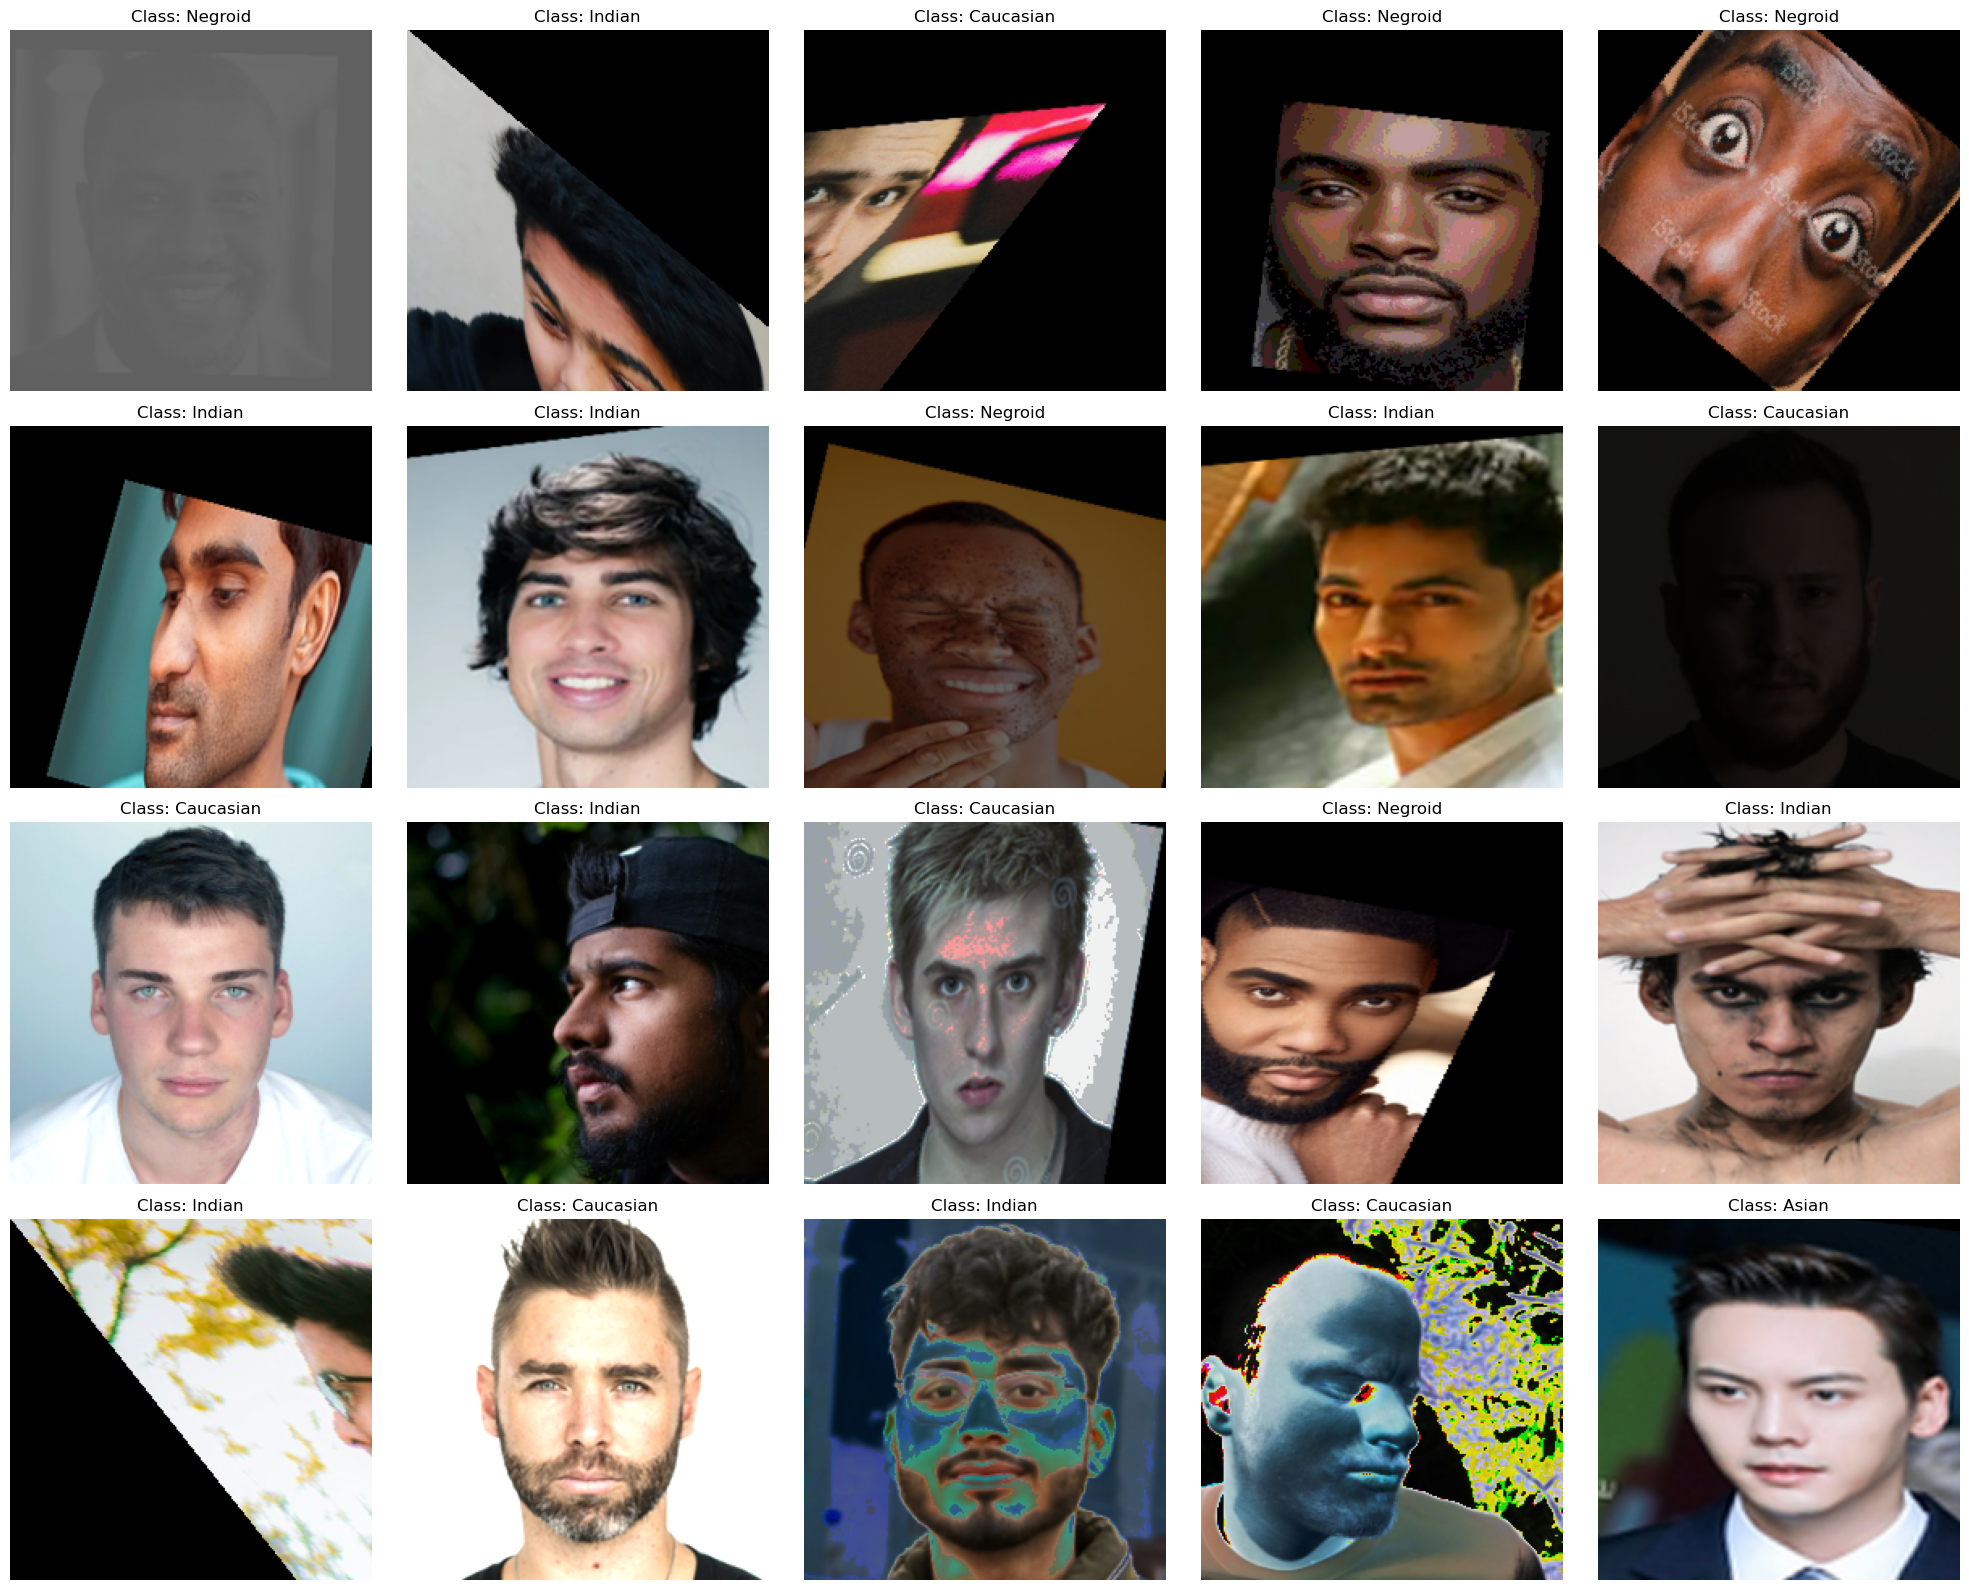

In [14]:
import matplotlib.pyplot as plt
import numpy as np


# Get one batch of images and labels
images, labels = next(iter(train_dataloader))

# Randomly select 20 indices
random_indices = np.random.choice(images.size(0), 20, replace=False)

# Convert from Tensor (C, H, W) to NumPy (H, W, C) for display
images = images.permute(0, 2, 3, 1).numpy()

plt.figure(figsize=(20, 16))
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[idx])
    plt.title(f"Class: {class_names[labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
images, labels = next(iter(train_dataloader))
images = images.permute(0, 2, 3, 1).numpy()
images[0].shape

(224, 224, 3)

# 3. Create the TinyVGG architecture model

In [16]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=56*56*hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.classifier(self.conv_block2(self.conv_block1(x)))

In [17]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes))
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=4, bias=True)
  )
)

# 4. Training and testing

## a) Train step and test step function

In [18]:
import torch.utils.data.dataloader


def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc= 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.cpu().detach().numpy() # for plotting loss in matplotlib later(requires numpy arr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc += (labels == y).sum().item()/len(y)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [19]:
def test_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module ):
    model.eval()
    test_loss, test_acc = 0, 0 
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.cpu().detach().numpy() # for plotting loss in matplotlib later(requires numpy arr)

            labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            test_acc += (labels == y).sum().item() / len(y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc


## b) Train function

In [20]:
from tqdm.auto import tqdm
def train(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(), epochs: int = 1, device = device):
  model.to(device)
  result = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, optimizer=optimizer, loss_fn=loss_fn)
    test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    result["train_loss"].append(train_loss)
    result["train_acc"].append(train_acc)
    result["test_loss"].append(test_loss)
    result["test_acc"].append(test_acc)
  return result

## c) Select loss_fn and optimizer

In [21]:
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

## d) Train the model

In [22]:
torch.manual_seed(27)
torch.cuda.manual_seed(27)

NUM_EPOCHS = 40

from timeit import default_timer as timer
start_time = timer()
model_0_result = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time on {device}: {end_time - start_time}")


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.4389 | Train acc: 0.2844 | Test loss: 1.3820 | Test acc: 0.2500
Epoch: 2 | Train loss: 1.3673 | Train acc: 0.3493 | Test loss: 1.3418 | Test acc: 0.3393
Epoch: 3 | Train loss: 1.3092 | Train acc: 0.3898 | Test loss: 1.1955 | Test acc: 0.5446
Epoch: 4 | Train loss: 1.2493 | Train acc: 0.4241 | Test loss: 1.1834 | Test acc: 0.5491
Epoch: 5 | Train loss: 1.1829 | Train acc: 0.5007 | Test loss: 1.1167 | Test acc: 0.5312
Epoch: 6 | Train loss: 1.1787 | Train acc: 0.5041 | Test loss: 1.0593 | Test acc: 0.5848
Epoch: 7 | Train loss: 1.0922 | Train acc: 0.5442 | Test loss: 1.1251 | Test acc: 0.5446
Epoch: 8 | Train loss: 1.0668 | Train acc: 0.5588 | Test loss: 1.0078 | Test acc: 0.6429
Epoch: 9 | Train loss: 1.0103 | Train acc: 0.5925 | Test loss: 1.0044 | Test acc: 0.6027
Epoch: 10 | Train loss: 0.9484 | Train acc: 0.6174 | Test loss: 0.9607 | Test acc: 0.6429
Epoch: 11 | Train loss: 0.9141 | Train acc: 0.6487 | Test loss: 1.0132 | Test acc: 0.6071
Epoch: 12 | Train l

# 5. Evaluating the model

In [23]:
import matplotlib.pyplot as plt

In [24]:
def plot_loss_curve(result):
    """Plot the training and test loss/acc curve from a dictionary"""
    train_loss = result["train_loss"]
    test_loss = result["test_loss"]
    train_acc = result["train_acc"]
    test_acc = result["test_acc"]
    epochs = range(len(train_loss))

    plt.figure(figsize=(10,6))
    # Plot the loss 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2 ,2)
    plt.plot(epochs, train_acc, label="Train acc")
    plt.plot(epochs, test_acc, label="Test acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

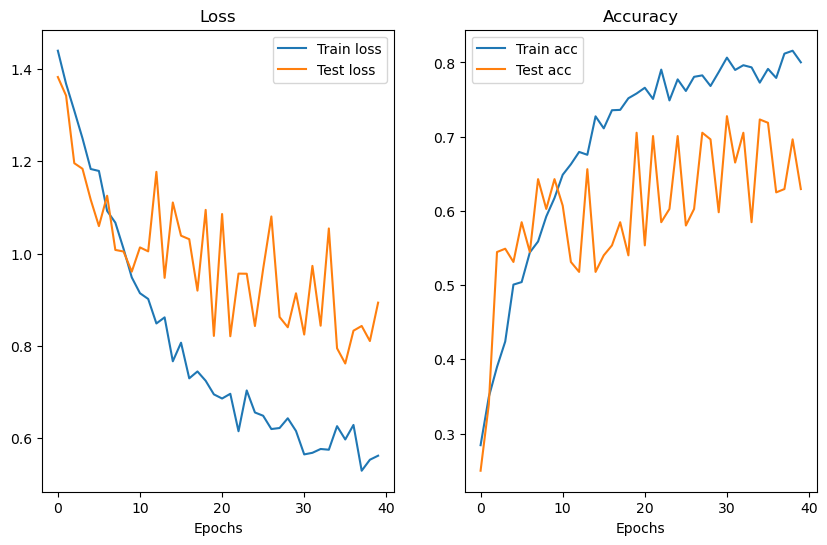

In [25]:
plot_loss_curve(model_0_result)

# 6. Make predictions using the trained model

## a) Functionalize making predictions

In [26]:
def make_preds(model: nn.Module, samples: list, device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in samples:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            logits = model(sample)
            pred_prob = torch.softmax(logits, dim=1)
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs) # turn list of tensors to a tensor of tensors
        

## b) Get sample data from test dataset

In [27]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=20):
  test_samples.append(sample)
  test_labels.append(label)
test_labels[0]

0

## c) Making predictions and plot them

In [28]:
pred_probs = make_preds(model_0, test_samples)
pred_labels= torch.argmax(pred_probs, dim=2)
pred_labels.shape

torch.Size([20, 1])

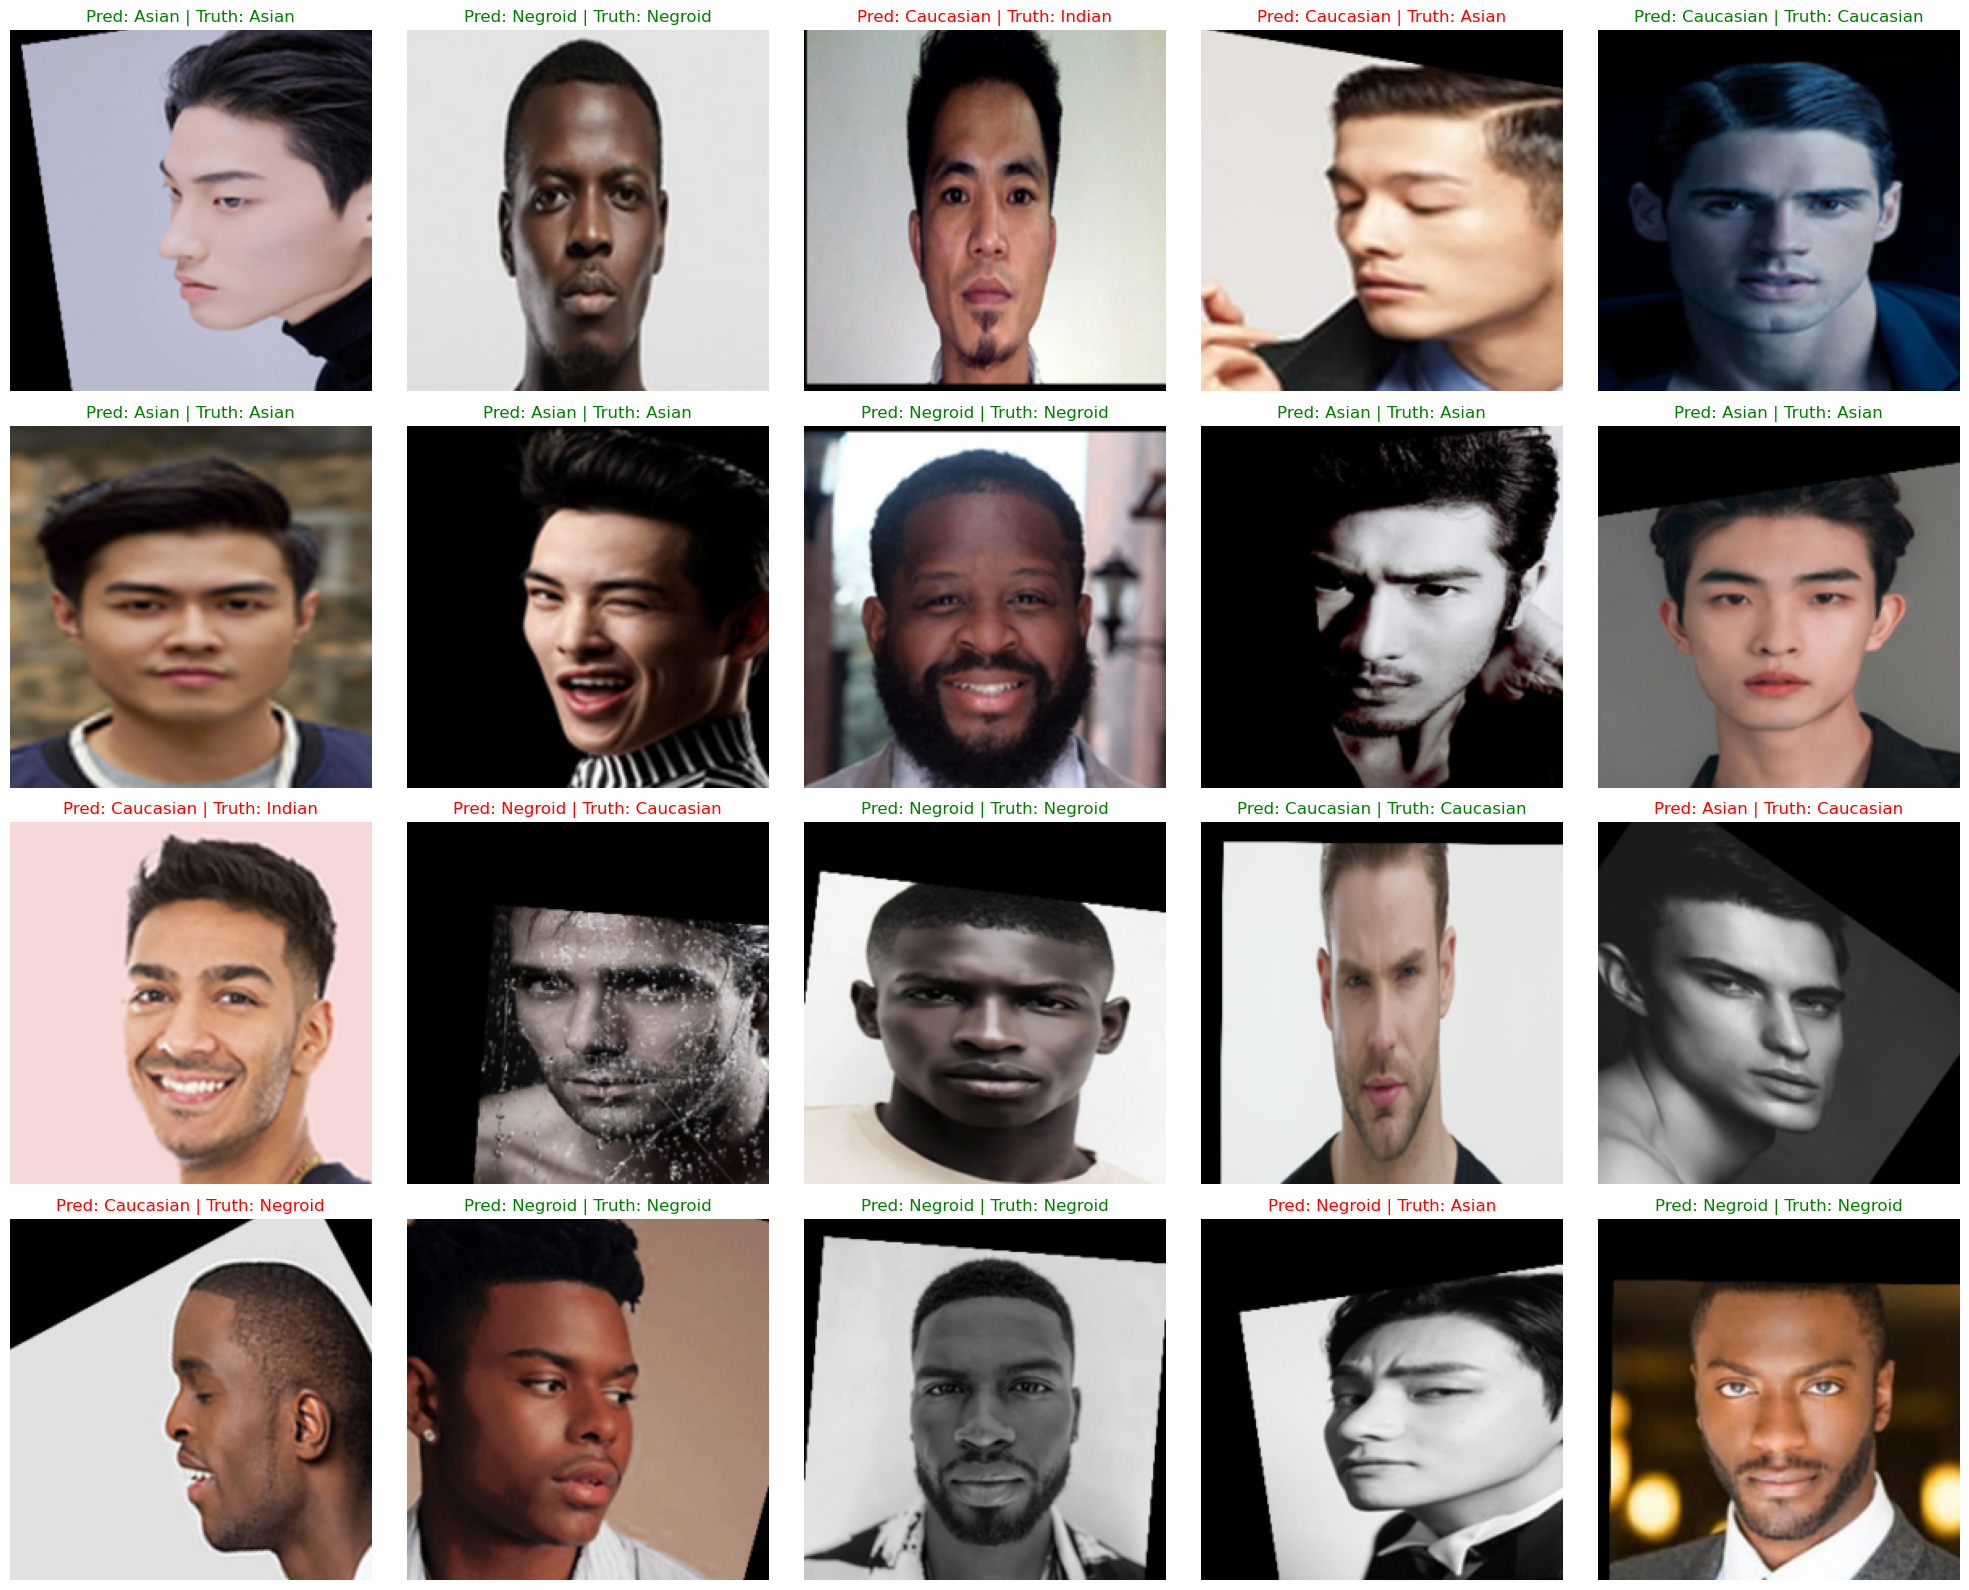

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 16))
for i, sample in enumerate(test_samples):
    plt.subplot(4, 5, i+1)
    plt.imshow(sample.permute(1, 2, 0))
    title_text = f"Pred: {class_names[pred_labels[i]]} | Truth: {class_names[test_labels[i]]}"
    if pred_labels[i] == test_labels[i]:
        plt.title(title_text, c="g")
    else:
        plt.title(title_text, c="r")

    plt.axis('off')
plt.tight_layout()
plt.show()

## d) Making a confusion matrix

In [30]:
torch.manual_seed(27)
all_pred_labels = []
model_0.to(device)
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)

        logits = model_0(X)
        label = torch.softmax(logits.squeeze(), dim=1).argmax(dim=1)
        all_pred_labels.append(label.cpu())
all_pred_labels_tensor = torch.cat(all_pred_labels) # list of single tensor -> tensor of elements

  0%|          | 0/7 [00:00<?, ?it/s]

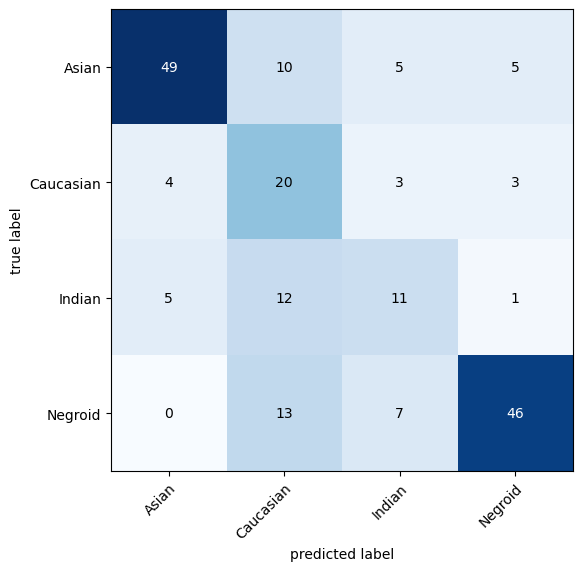

In [33]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_mat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
conf_mat_tensor = conf_mat(preds=all_pred_labels_tensor, target=torch.tensor(test_data.targets))

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(),
    class_names=class_names,
    figsize=(8,6)
)

In [32]:
class_weights, train_data.classes, class_train_imgs

(tensor([0.0036, 0.0041, 0.0043, 0.0038]),
 ['Asian', 'Caucasian', 'Indian', 'Negroid'],
 {'Asian': 274, 'Caucasian': 243, 'Indian': 234, 'Negroid': 262})